In [1]:
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.dataset import LocalImageDataset, get_split_indices
from model.ResNetSR import ResNetSR
from model.utils import get_device, train_model_single_epoch, validate_model_single_epoch, save_checkpoint, save_samples, CombinedLoss

In [2]:
with open("data/test_indices.json", "r") as f:
    test_indices = json.load(f)

In [3]:
len(test_indices)

594

In [4]:
INPUT_DIR = "data/resolution_128"
TARGET_DIR = "data/resolution_256"
NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.01

GRAD_CLIP = 1
EDGE_WEIGHT = 0.3
PSNR_WEIGHT = 0.3

history = {
    "train_loss": [],
    "train_psnr": [],
    "val_loss": [],
    "val_psnr": []
}

In [5]:
num_images = len([f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg', '.webp'))])
train_indices, val_indices = get_split_indices(num_images, test_indices)

train_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, train_indices), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=BATCH_SIZE, shuffle=False)

In [6]:
best_val_loss = float('inf')

save_ckpt = 2
checkpoint_dir = "ckpt"

n_samples = 5
samples_to_visualize = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=n_samples, shuffle=False)

sample_dir = "samples"

train_losses = []
val_losses = []

In [7]:
device = get_device()
model = ResNetSR(upscale_factor=2, num_res_blocks=2, num_channels=1, num_features=32)
model = model.to(device)
mae_loss = nn.L1Loss()
criterion = CombinedLoss(mae_loss, EDGE_WEIGHT)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=60)

In [8]:
# for epoch in range(1, NUM_EPOCHS + 1):
#     train_loss, train_psnr = train_model_single_epoch(model, train_loader, criterion, optimizer, device, scaler=None, grad_clip=GRAD_CLIP)
#     val_loss, val_psnr = validate_model_single_epoch(model, val_loader, criterion, device)
#     current_lr = scheduler.get_last_lr()[0]
#     print(f"[Epoch {epoch}/{NUM_EPOCHS}]",
#             f"Train Loss: {train_loss:.4f}, PSNR: {train_psnr:.2f} | "
#             f"Val Loss: {val_loss:.4f}, PSNR: {val_psnr:.2f} | "
#             f"lr: {round(current_lr, 5)}")

#     if epoch % save_ckpt == 0:
#         save_checkpoint(epoch+1, model, optimizer, history, checkpoint_dir)

#         save_samples(epoch+1, model, val_loader, device, sample_dir, samples_to_visualize)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         save_checkpoint(0, model, optimizer, history, checkpoint_dir)

#     scheduler.step(val_loss)

#     history["train_loss"].append(train_loss)
#     history["train_psnr"].append(train_psnr)
#     history["val_loss"].append(val_loss)
#     history["val_psnr"].append(val_psnr)

In [ ]:
def train_model_for_resolution_pairs(resol_1, resol_2, psnr_weight=PSNR_WEIGHT):
    INPUT_DIR = f"data/resolution_{resol_1}"
    TARGET_DIR = f"data/resolution_{resol_2}"

    num_images = len([f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg', '.webp'))])
    train_indices, val_indices = get_split_indices(num_images, test_indices)

    train_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, train_indices), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=BATCH_SIZE, shuffle=False)

    best_val_loss = float('inf')

    save_ckpt = 2
    checkpoint_dir = f"ckpt/resolution_{resol_1}_{resol_2}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    n_samples = 5
    samples_to_visualize = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=n_samples, shuffle=False)

    sample_dir = f"samples_{resol_1}_{resol_2}"


    device = get_device()
    model = ResNetSR(upscale_factor=2, num_res_blocks=2, num_channels=1, num_features=32)
    model = model.to(device)
    mae_loss = nn.L1Loss()
    criterion = CombinedLoss(mae_loss, EDGE_WEIGHT, psnr_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',  # Focus on maximizing PSNR
        factor=.2,  # More aggressive reduction
        patience=2,   # Reduce LR sooner
        threshold=0.01,  # Smaller threshold for improvement
        verbose=True
    )

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_psnr = train_model_single_epoch(model, train_loader, criterion, optimizer, device, scaler=None, grad_clip=GRAD_CLIP)
        val_loss, val_psnr = validate_model_single_epoch(model, val_loader, criterion, device)
        current_lr = scheduler.get_last_lr()[0]
        print(f"[Epoch {epoch}/{NUM_EPOCHS}]",
                f"Train Loss: {train_loss:.4f}, PSNR: {train_psnr:.2f} | "
                f"Val Loss: {val_loss:.4f}, PSNR: {val_psnr:.2f} | "
                f"lr: {round(current_lr, 5)}")

        if epoch % save_ckpt == 0:
            save_checkpoint(epoch+1, model, optimizer, history, checkpoint_dir)

            save_samples(epoch+1, model, val_loader, device, sample_dir, samples_to_visualize)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(0, model, optimizer, history, checkpoint_dir)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["train_psnr"].append(train_psnr)
        history["val_loss"].append(val_loss)
        history["val_psnr"].append(val_psnr)

    sns.lineplot(
        x=range(1, epoch + 1),
        y=history["train_psnr"],
        label="Train PSNR",
        color="blue"
    )
    sns.lineplot(
        x=range(1, epoch + 1),
        y=history["val_psnr"],
        label="Validation PSNR",
        color="orange"
    )
    plt.title("PSNR over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()

    os.mkdir("plots", exist_ok=True)
    plt.savefig(f"plots/psnr_plot_{resol_1}_{resol_2}.png")

    return history

/Users/janysli/miniconda3/envs/text_super_resol/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training: 100%|██████████| 67/67 [00:07<00:00,  8.96it/s, loss=-3.8, psnr=13.5]   


[Epoch 1/30] Train Loss: 34.1655, PSNR: 2.99 | Val Loss: -3.7655, PSNR: 13.42 | lr: 0.01
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00,  9.64it/s, loss=-3.95, psnr=13.9]


[Epoch 2/30] Train Loss: -3.8369, PSNR: 13.63 | Val Loss: -3.9131, PSNR: 13.86 | lr: 0.01
Model checkpoint saved at ckpt/resolution_64_128/ckpt_3
Saved 5 samples at epoch 3 to samples_64_128/epoch_3_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.29it/s, loss=-4.01, psnr=14.1]


[Epoch 3/30] Train Loss: -3.9270, PSNR: 13.88 | Val Loss: -3.9551, PSNR: 13.94 | lr: 0.01
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.34it/s, loss=-3.94, psnr=13.9]


[Epoch 4/30] Train Loss: -3.9698, PSNR: 13.99 | Val Loss: -3.9667, PSNR: 13.98 | lr: 0.01
Model checkpoint saved at ckpt/resolution_64_128/ckpt_5
Saved 5 samples at epoch 5 to samples_64_128/epoch_5_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00,  9.63it/s, loss=-4.08, psnr=14.3]


[Epoch 5/30] Train Loss: -4.0086, PSNR: 14.10 | Val Loss: -4.0250, PSNR: 14.14 | lr: 0.002
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.00it/s, loss=-4.02, psnr=14.1]


[Epoch 6/30] Train Loss: -4.0245, PSNR: 14.14 | Val Loss: -4.0338, PSNR: 14.16 | lr: 0.002
Model checkpoint saved at ckpt/resolution_64_128/ckpt_7
Saved 5 samples at epoch 7 to samples_64_128/epoch_7_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.05it/s, loss=-4.06, psnr=14.2]


[Epoch 7/30] Train Loss: -4.0357, PSNR: 14.17 | Val Loss: -4.0473, PSNR: 14.20 | lr: 0.002
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.34it/s, loss=-4.07, psnr=14.3]


[Epoch 8/30] Train Loss: -4.0432, PSNR: 14.19 | Val Loss: -4.0495, PSNR: 14.21 | lr: 0.0004
Model checkpoint saved at ckpt/resolution_64_128/ckpt_9
Saved 5 samples at epoch 9 to samples_64_128/epoch_9_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00,  9.97it/s, loss=-4.09, psnr=14.3]


[Epoch 9/30] Train Loss: -4.0462, PSNR: 14.20 | Val Loss: -4.0539, PSNR: 14.22 | lr: 0.0004
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.56it/s, loss=-4.09, psnr=14.3]


[Epoch 10/30] Train Loss: -4.0479, PSNR: 14.20 | Val Loss: -4.0547, PSNR: 14.22 | lr: 0.0004
Model checkpoint saved at ckpt/resolution_64_128/ckpt_11
Saved 5 samples at epoch 11 to samples_64_128/epoch_11_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00,  9.66it/s, loss=-3.97, psnr=14]  


[Epoch 11/30] Train Loss: -4.0501, PSNR: 14.21 | Val Loss: -4.0553, PSNR: 14.22 | lr: 8e-05
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.33it/s, loss=-4.05, psnr=14.2]


[Epoch 12/30] Train Loss: -4.0509, PSNR: 14.21 | Val Loss: -4.0563, PSNR: 14.23 | lr: 8e-05
Model checkpoint saved at ckpt/resolution_64_128/ckpt_13
Saved 5 samples at epoch 13 to samples_64_128/epoch_13_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.43it/s, loss=-3.98, psnr=14]  


[Epoch 13/30] Train Loss: -4.0512, PSNR: 14.21 | Val Loss: -4.0547, PSNR: 14.22 | lr: 8e-05


Training: 100%|██████████| 67/67 [00:07<00:00,  8.49it/s, loss=-4.11, psnr=14.4]


[Epoch 14/30] Train Loss: -4.0522, PSNR: 14.21 | Val Loss: -4.0560, PSNR: 14.22 | lr: 2e-05
Model checkpoint saved at ckpt/resolution_64_128/ckpt_15
Saved 5 samples at epoch 15 to samples_64_128/epoch_15_samples.png


Training: 100%|██████████| 67/67 [00:06<00:00, 10.35it/s, loss=-4.09, psnr=14.3]


[Epoch 15/30] Train Loss: -4.0520, PSNR: 14.21 | Val Loss: -4.0557, PSNR: 14.22 | lr: 2e-05


Training: 100%|██████████| 67/67 [00:06<00:00,  9.85it/s, loss=-4.1, psnr=14.3] 


[Epoch 16/30] Train Loss: -4.0520, PSNR: 14.21 | Val Loss: -4.0572, PSNR: 14.23 | lr: 2e-05
Model checkpoint saved at ckpt/resolution_64_128/ckpt_17
Saved 5 samples at epoch 17 to samples_64_128/epoch_17_samples.png
Model checkpoint saved at ckpt/resolution_64_128/ckpt_0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.12it/s, loss=-4.05, psnr=14.2]


[Epoch 17/30] Train Loss: -4.0525, PSNR: 14.22 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.20it/s, loss=-4.05, psnr=14.2]


[Epoch 18/30] Train Loss: -4.0524, PSNR: 14.21 | Val Loss: -4.0564, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_19
Saved 5 samples at epoch 19 to samples_64_128/epoch_19_samples.png


Training: 100%|██████████| 67/67 [00:06<00:00, 10.41it/s, loss=-4.12, psnr=14.4]


[Epoch 19/30] Train Loss: -4.0530, PSNR: 14.22 | Val Loss: -4.0564, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:06<00:00, 10.41it/s, loss=-4.01, psnr=14.1]


[Epoch 20/30] Train Loss: -4.0524, PSNR: 14.21 | Val Loss: -4.0565, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_21
Saved 5 samples at epoch 21 to samples_64_128/epoch_21_samples.png


Training: 100%|██████████| 67/67 [00:06<00:00, 10.24it/s, loss=-3.99, psnr=14]  


[Epoch 21/30] Train Loss: -4.0522, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:07<00:00,  9.54it/s, loss=-4.06, psnr=14.2]


[Epoch 22/30] Train Loss: -4.0526, PSNR: 14.22 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_23
Saved 5 samples at epoch 23 to samples_64_128/epoch_23_samples.png


Training: 100%|██████████| 67/67 [00:07<00:00,  9.12it/s, loss=-4.06, psnr=14.2]


[Epoch 23/30] Train Loss: -4.0522, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:07<00:00,  8.45it/s, loss=-4.03, psnr=14.1]


[Epoch 24/30] Train Loss: -4.0522, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_25
Saved 5 samples at epoch 25 to samples_64_128/epoch_25_samples.png


Training: 100%|██████████| 67/67 [00:08<00:00,  8.13it/s, loss=-4.04, psnr=14.2]


[Epoch 25/30] Train Loss: -4.0524, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:08<00:00,  8.35it/s, loss=-4.04, psnr=14.2]


[Epoch 26/30] Train Loss: -4.0523, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_27
Saved 5 samples at epoch 27 to samples_64_128/epoch_27_samples.png


Training: 100%|██████████| 67/67 [00:07<00:00,  8.59it/s, loss=-4.03, psnr=14.1]


[Epoch 27/30] Train Loss: -4.0525, PSNR: 14.22 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:07<00:00,  8.45it/s, loss=-4.09, psnr=14.3]


[Epoch 28/30] Train Loss: -4.0526, PSNR: 14.22 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_29
Saved 5 samples at epoch 29 to samples_64_128/epoch_29_samples.png


Training: 100%|██████████| 67/67 [00:07<00:00,  8.62it/s, loss=-3.94, psnr=13.9]


[Epoch 29/30] Train Loss: -4.0523, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0


Training: 100%|██████████| 67/67 [00:07<00:00,  8.76it/s, loss=-4.1, psnr=14.3] 


[Epoch 30/30] Train Loss: -4.0524, PSNR: 14.21 | Val Loss: -4.0566, PSNR: 14.23 | lr: 0.0
Model checkpoint saved at ckpt/resolution_64_128/ckpt_31
Saved 5 samples at epoch 31 to samples_64_128/epoch_31_samples.png


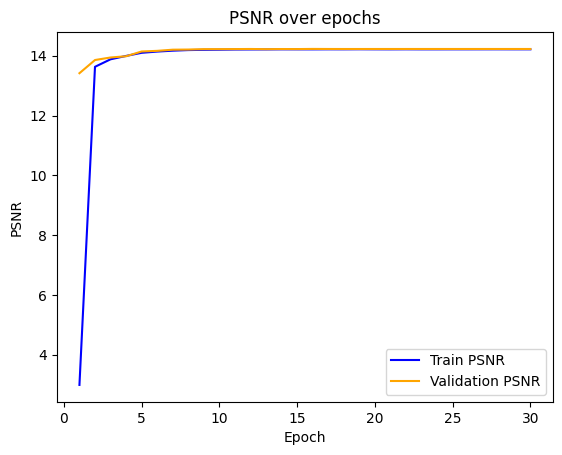

FileNotFoundError: [Errno 2] No such file or directory: 'plots/psnr_plot_64_128.png'

<Figure size 640x480 with 0 Axes>

In [ ]:
train_model_for_resolution_pairs(64, 128)

In [ ]:
train_model_for_resolution_pairs(128, 256)

Training: 100%|██████████| 67/67 [00:34<00:00,  1.95it/s, loss=0.226, psnr=15.9]


[Epoch 1/30] Train Loss: 9.4055, PSNR: 6.08 | Val Loss: 0.2283, PSNR: 15.72 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.41it/s, loss=0.193, psnr=16.3]


[Epoch 2/30] Train Loss: 0.2054, PSNR: 16.15 | Val Loss: 0.1873, PSNR: 16.52 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_3
Saved 5 samples at epoch 3 to samples_128_256/epoch_3_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.42it/s, loss=0.152, psnr=17.1]


[Epoch 3/30] Train Loss: 0.1650, PSNR: 16.85 | Val Loss: 0.1488, PSNR: 17.28 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:28<00:00,  2.38it/s, loss=0.143, psnr=17.4]


[Epoch 4/30] Train Loss: 0.1439, PSNR: 17.42 | Val Loss: 0.1384, PSNR: 17.68 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_5
Saved 5 samples at epoch 5 to samples_128_256/epoch_5_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.127, psnr=17.9]


[Epoch 5/30] Train Loss: 0.1312, PSNR: 17.86 | Val Loss: 0.1262, PSNR: 18.07 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.45it/s, loss=0.113, psnr=18.5]


[Epoch 6/30] Train Loss: 0.1179, PSNR: 18.34 | Val Loss: 0.1135, PSNR: 18.51 | lr: 0.005
Model checkpoint saved at ckpt/ckpt_7
Saved 5 samples at epoch 7 to samples_128_256/epoch_7_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:28<00:00,  2.34it/s, loss=0.103, psnr=19]   


[Epoch 7/30] Train Loss: 0.1111, PSNR: 18.63 | Val Loss: 0.1107, PSNR: 18.70 | lr: 0.005
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.41it/s, loss=0.106, psnr=18.9] 


[Epoch 8/30] Train Loss: 0.1065, PSNR: 18.85 | Val Loss: 0.1045, PSNR: 18.95 | lr: 0.005
Model checkpoint saved at ckpt/ckpt_9
Saved 5 samples at epoch 9 to samples_128_256/epoch_9_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.40it/s, loss=0.11, psnr=18.9]  


[Epoch 9/30] Train Loss: 0.1016, PSNR: 19.10 | Val Loss: 0.1116, PSNR: 18.80 | lr: 0.005


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.0945, psnr=19.5]


[Epoch 10/30] Train Loss: 0.0977, PSNR: 19.29 | Val Loss: 0.0948, PSNR: 19.41 | lr: 0.0025
Model checkpoint saved at ckpt/ckpt_11
Saved 5 samples at epoch 11 to samples_128_256/epoch_11_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.40it/s, loss=0.0887, psnr=19.7]


[Epoch 11/30] Train Loss: 0.0937, PSNR: 19.48 | Val Loss: 0.0924, PSNR: 19.55 | lr: 0.0025
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.45it/s, loss=0.0841, psnr=20]  


[Epoch 12/30] Train Loss: 0.0915, PSNR: 19.61 | Val Loss: 0.0904, PSNR: 19.64 | lr: 0.0025
Model checkpoint saved at ckpt/ckpt_13
Saved 5 samples at epoch 13 to samples_128_256/epoch_13_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.0866, psnr=19.9]


[Epoch 13/30] Train Loss: 0.0894, PSNR: 19.72 | Val Loss: 0.0879, PSNR: 19.80 | lr: 0.0025
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.45it/s, loss=0.094, psnr=19.5] 


[Epoch 14/30] Train Loss: 0.0870, PSNR: 19.85 | Val Loss: 0.0862, PSNR: 19.89 | lr: 0.00125
Model checkpoint saved at ckpt/ckpt_15
Saved 5 samples at epoch 15 to samples_128_256/epoch_15_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.0853, psnr=20]  


[Epoch 15/30] Train Loss: 0.0858, PSNR: 19.92 | Val Loss: 0.0854, PSNR: 19.94 | lr: 0.00125
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.46it/s, loss=0.0902, psnr=19.7]


[Epoch 16/30] Train Loss: 0.0847, PSNR: 19.98 | Val Loss: 0.0839, PSNR: 20.03 | lr: 0.00125
Model checkpoint saved at ckpt/ckpt_17
Saved 5 samples at epoch 17 to samples_128_256/epoch_17_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:28<00:00,  2.35it/s, loss=0.0884, psnr=19.8]


[Epoch 17/30] Train Loss: 0.0835, PSNR: 20.05 | Val Loss: 0.0829, PSNR: 20.09 | lr: 0.00125
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.076, psnr=20.5] 


[Epoch 18/30] Train Loss: 0.0824, PSNR: 20.12 | Val Loss: 0.0821, PSNR: 20.14 | lr: 0.00063
Model checkpoint saved at ckpt/ckpt_19
Saved 5 samples at epoch 19 to samples_128_256/epoch_19_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.43it/s, loss=0.0755, psnr=20.5]


[Epoch 19/30] Train Loss: 0.0819, PSNR: 20.15 | Val Loss: 0.0814, PSNR: 20.17 | lr: 0.00063
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.44it/s, loss=0.0797, psnr=20.3]


[Epoch 20/30] Train Loss: 0.0814, PSNR: 20.18 | Val Loss: 0.0809, PSNR: 20.20 | lr: 0.00063
Model checkpoint saved at ckpt/ckpt_21
Saved 5 samples at epoch 21 to samples_128_256/epoch_21_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.41it/s, loss=0.0764, psnr=20.5]


[Epoch 21/30] Train Loss: 0.0807, PSNR: 20.22 | Val Loss: 0.0805, PSNR: 20.23 | lr: 0.00063
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.42it/s, loss=0.0764, psnr=20.5]


[Epoch 22/30] Train Loss: 0.0802, PSNR: 20.25 | Val Loss: 0.0800, PSNR: 20.26 | lr: 0.00031
Model checkpoint saved at ckpt/ckpt_23
Saved 5 samples at epoch 23 to samples_128_256/epoch_23_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.40it/s, loss=0.0804, psnr=20.3]


[Epoch 23/30] Train Loss: 0.0799, PSNR: 20.27 | Val Loss: 0.0797, PSNR: 20.28 | lr: 0.00031
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.42it/s, loss=0.0795, psnr=20.3]


[Epoch 24/30] Train Loss: 0.0795, PSNR: 20.29 | Val Loss: 0.0793, PSNR: 20.30 | lr: 0.00031
Model checkpoint saved at ckpt/ckpt_25
Saved 5 samples at epoch 25 to samples_128_256/epoch_25_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:28<00:00,  2.39it/s, loss=0.0783, psnr=20.4]


[Epoch 25/30] Train Loss: 0.0793, PSNR: 20.31 | Val Loss: 0.0792, PSNR: 20.32 | lr: 0.00031
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:58<00:00,  1.15it/s, loss=0.0834, psnr=20.1]


[Epoch 26/30] Train Loss: 0.0790, PSNR: 20.33 | Val Loss: 0.0788, PSNR: 20.33 | lr: 0.00016
Model checkpoint saved at ckpt/ckpt_27
Saved 5 samples at epoch 27 to samples_128_256/epoch_27_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:30<00:00,  2.21it/s, loss=0.0776, psnr=20.4]


[Epoch 27/30] Train Loss: 0.0788, PSNR: 20.34 | Val Loss: 0.0787, PSNR: 20.34 | lr: 0.00016
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [05:27<00:00,  4.88s/it, loss=0.0819, psnr=20.2]  


[Epoch 28/30] Train Loss: 0.0786, PSNR: 20.35 | Val Loss: 0.0785, PSNR: 20.35 | lr: 0.00016
Model checkpoint saved at ckpt/ckpt_29
Saved 5 samples at epoch 29 to samples_128_256/epoch_29_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:55<00:00,  1.21it/s, loss=0.0782, psnr=20.4]


[Epoch 29/30] Train Loss: 0.0785, PSNR: 20.36 | Val Loss: 0.0784, PSNR: 20.35 | lr: 0.00016
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [00:27<00:00,  2.42it/s, loss=0.0795, psnr=20.3]


[Epoch 30/30] Train Loss: 0.0783, PSNR: 20.37 | Val Loss: 0.0782, PSNR: 20.37 | lr: 8e-05
Model checkpoint saved at ckpt/ckpt_31
Saved 5 samples at epoch 31 to samples_128_256/epoch_31_samples.png
Model checkpoint saved at ckpt/ckpt_0


In [ ]:
train_model_for_resolution_pairs(256, 512)

Training: 100%|██████████| 67/67 [2:36:16<00:00, 139.94s/it, loss=0.135, psnr=19.4]   


[Epoch 1/30] Train Loss: 19.0649, PSNR: -2.96 | Val Loss: 0.1273, PSNR: 20.24 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [41:02<00:00, 36.76s/it, loss=0.16, psnr=16.9]  


[Epoch 2/30] Train Loss: 0.2267, PSNR: 17.36 | Val Loss: 0.3321, PSNR: 10.29 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_3
Saved 5 samples at epoch 3 to samples_256_512/epoch_3_samples.png


Training: 100%|██████████| 67/67 [1:00:27<00:00, 54.15s/it, loss=0.1, psnr=21.7]    


[Epoch 3/30] Train Loss: 0.1504, PSNR: 19.41 | Val Loss: 0.1403, PSNR: 19.20 | lr: 0.01


Training: 100%|██████████| 67/67 [1:33:15<00:00, 83.52s/it, loss=0.112, psnr=20.8]   


[Epoch 4/30] Train Loss: 0.2149, PSNR: 16.72 | Val Loss: 0.1202, PSNR: 20.77 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_5
Saved 5 samples at epoch 5 to samples_256_512/epoch_5_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [57:10<00:00, 51.21s/it, loss=0.139, psnr=19.6]   


[Epoch 5/30] Train Loss: 1.0411, PSNR: 11.72 | Val Loss: 0.1432, PSNR: 19.02 | lr: 0.01


Training: 100%|██████████| 67/67 [1:18:47<00:00, 70.57s/it, loss=0.0949, psnr=21.7] 


[Epoch 6/30] Train Loss: 0.3516, PSNR: 18.81 | Val Loss: 0.0965, PSNR: 21.19 | lr: 0.01
Model checkpoint saved at ckpt/ckpt_7
Saved 5 samples at epoch 7 to samples_256_512/epoch_7_samples.png
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [40:51<00:00, 36.58s/it, loss=0.0752, psnr=22]  


[Epoch 7/30] Train Loss: 0.0806, PSNR: 22.01 | Val Loss: 0.0748, PSNR: 22.15 | lr: 0.005
Model checkpoint saved at ckpt/ckpt_0


Training: 100%|██████████| 67/67 [1:46:44<00:00, 95.60s/it, loss=0.0529, psnr=23.4]   
